## Titanic Survival Prediction: Implementing a Logistic Regression Model From Scratch

The purpose of this project is to implement a logistic regression model from scratch and test it on the Titanic Kaggle competition to predict whether each passenger survived based on a number of descriptive features such as age, fare and passenger class.

#### Importing Required Packages

In [1]:
import numpy as np 
import pandas as pd 
import re 
import seaborn as sns
import matplotlib.pylab as plt

### Loading the Data

I am going to start by loading the Titanic dataset which was downloaded from https://www.kaggle.com/c/titanic/data and saved locally. The train and test datasets are combined so that all data pre-processing steps can be performed on both datasets at the same time.

In [2]:
train_data = pd.read_csv('titanic/train.csv')
test_data = pd.read_csv('titanic/test.csv')
data_all = pd.concat([train_data, test_data], axis=0, sort=True)

### Data Exploration

#### Describing the Data

As shown below, the training data consists of 891 training instances and 12 features, including the 'Survived' feature which is the target feature for this prediction problem. The test data consists of 418 instances and 11 features, as the target feature is not included for this dataset. The combined dataset consists of 1309 instances.

In [3]:
print('training data shape:', train_data.shape)
print('test data shape:',test_data.shape)
print('combined data shape:', data_all.shape)

training data shape: (891, 12)
test data shape: (418, 11)
combined data shape: (1309, 12)


In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


According to the information provided in the competition, the attributes in the dataset are defined as follows: 
* PassengerId - Passenger ID number.  
* Survived - 0 for passengers who did not survive and 1 for passengers who did survive.  
* Pclass - The class of the passenger. 1 is first class, 2 is second class and 3 is third class. The information provided notes that this attribute is a proxy for socio-economic status where 1 corresponds to upper class, 2 corresponds to middle class and 3 corresponds to lower class. 
* Name - The name of the passenger. 
* Sex - The sex of the passenger.  
* Age -  The age of the passenger in years. The age is fractional if less than 1 and estimated ages are in the format xx.5. 
* SibSp - The number of siblings or spouses aboard the Titanic. 
* Parch - The number of parents or children aboard the Titanic. Children who were travelling alone with a nanny have a value of 0.
* Ticket - Ticket number. 
* Fare - Passenger fare. 
* Cabin - Cabin number. 
* Embarked - Port of embarkation. C = Cherbourg, Q = Queenstown, S = Southampton. 

The data types of the features are shown below. The continuous features in this dataset are Age, SibSp, Parch and Fare and the categorical features in this dataset are Survived (the target feature), Pclass, Sex and Embarked. Other features that may or may not be useful for prediction are the Cabin number, the Ticket number and the Name. PassengerId is not a feature that will be used for prediction.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


As shown below, the Age values range from less than 1 years old to 80 years old with a median age of 28 years old. The number of siblings or spouses of the passengars ranges from 0 to 8 with a median of 0, and the number of parents or children ranges from 0 to 6 with a median of 0. The fare values range from 0 to 512 but a median fare of 14.5.


In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


A summary of the categorical features are shown below. The two genders that are represented in this dataset are male and female, with more male passengers than female. There are 147 different cabin numbers represented in the dataset and 3 different ports of embarkment. These, along with the continuous features will be further explored to determine which features are useful in predicting the survival rate.

In [7]:
train_data.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Ryan, Mr. Patrick",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
num_cols = ['Age', 'Fare', 'Parch','SibSp']
cat_cols = ['Embarked','Pclass', 'Sex']

#### Visualizing the Numerical Data

The figure below shows the relationship between some of the numerical features, color coded by the survival for the train data. Only numerical features that made sense to visualize are shown below. Based on the data shown below, a linear decision boundary is probably sufficient to separate the classes with a decent degree of accuracy. Therefore, a standard implementation of a logistic regression model that assumes a linear relationship between descriptive features and the target feature will be implemented (Kelleher et al., 2015, p. 365). 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


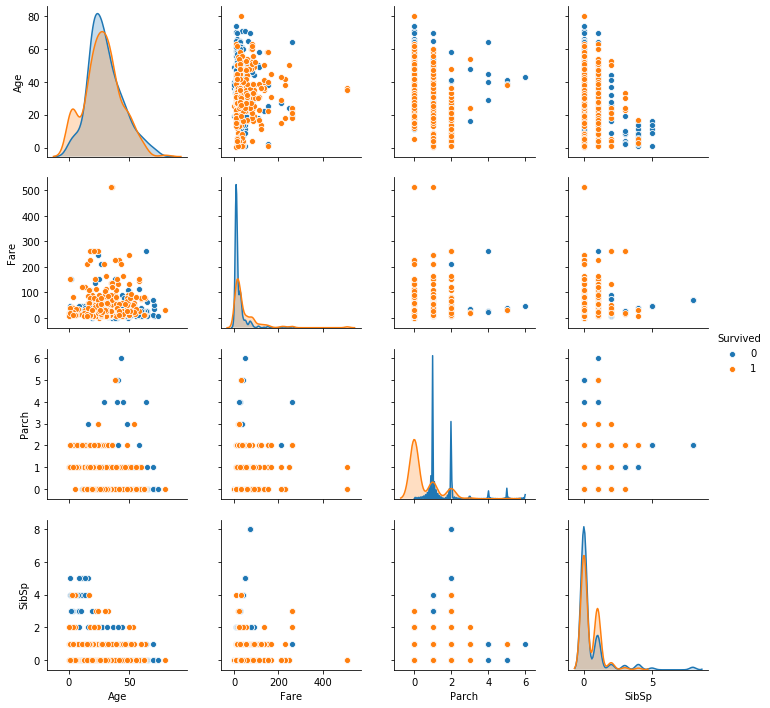

In [9]:
sns.pairplot(data = train_data, vars = num_cols, hue = 'Survived')

#### Visualizing the Categorical Data

The plots below show the survival rate of passengers by three categorical features: "Embarked", "Pclass" and "Sex". As shown, passangers who embarked from Cherbourg (C) had a higher survival rate than passengers who embarked from either of the other two ports. Passengers in first class had a significantly higher survival rate than those in lower passenger classes and the survival rate decreases as the passenger class increases. Lastly, the survival rate of female passengers is higher than the male passengers.

In [10]:
def pairgrid(data,y,x):
    
    '''
    function to visualize categorical data written based on expample provided in Seaborn documentation: 
    http://seaborn.pydata.org/examples/paired_pointplots.html
    '''

    g = sns.PairGrid(data=data, y_vars=y,
                 x_vars=x,
                 height=5, aspect=1.5)

    g.map(sns.pointplot, scale=1.3, errwidth=4)
    g.set(ylim=(0, 1))
    sns.despine(fig=g.fig, left=True)

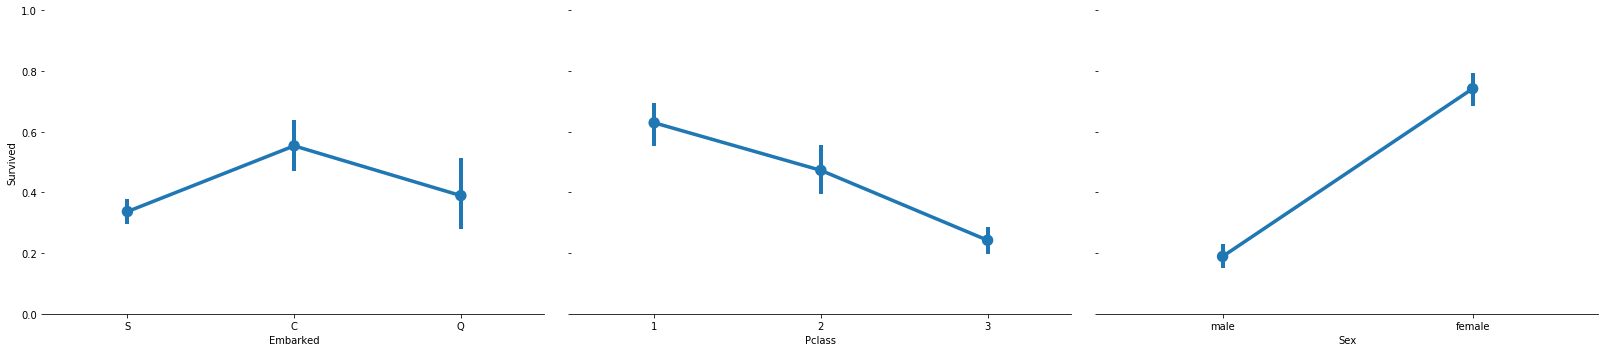

In [11]:
pairgrid(data=train_data, y='Survived', x=cat_cols)

#### Assessing Data Quality

Next, the data will be examined for missing values.

In [12]:
def missing_values(data): 
    '''
    data is the dataframe containing the data
    '''
    
    missing_dict = {'feature' : [],
                'missing val count': [], 
                'missing val %': []}
    
    for item in data.columns: 
        missing_dict['feature'].append(item)
        missing_no = sum(data[item].isnull()==True)
        missing_pct = sum(data[item].isnull()==True) / len(data[item]) * 100
        missing_dict['missing val count'].append(missing_no)
        missing_dict['missing val %'].append(missing_pct)
        
    missing_counts = pd.DataFrame.from_dict(missing_dict).sort_values(by = ['missing val %'], ascending = False)
    
    return missing_counts[missing_counts['missing val count']!=0]

In [13]:
missing_val = missing_values(data_all)
missing_val

,feature,missing val count,missing val %
1,Cabin,1014,77.463713
10,Survived,418,31.932773
0,Age,263,20.091673
2,Embarked,2,0.152788
3,Fare,1,0.076394


Based on the information above, "Cabin", "Age", "Embarked", and "Fare" are missing values. The missing values in the 'Survived' feature are from the testing dataset, so these do not need to be handled. The dataframe shown below confirms that there are not missing values for 'Survived' in the training data. 

In [14]:
missing_val_training = missing_values(train_data)
missing_val_training

,feature,missing val count,missing val %
10,Cabin,687,77.104377
5,Age,177,19.865320
11,Embarked,2,0.224467


As the "Cabin" feature has a large percentage of missing values, this feature will not be used for analysis so imputation is not required to handle missing values. To proceed with the analysis missing values for the "Age", "Embarked" and "Fare" features should be handled.

#### Handling Missing Age Values

To impute the missing age values, I'm going to extract the titles from the names of the passengers and fill in missing age values with the median age value from each title type. I got the idea for this approach by reviewing a number of other notebooks, including a notebook published by James Leslie who used passenger titles to impute the missing age values (Leslie, 2018). 

I'm going to create some new features by combining the passenger's title with other attributes and I'm going to visualize the data to determine which new feature I should use to impute the missing Age data.

In [15]:
def extract_titles(data_input,to_extract = 'titles'): 
    '''
    data: the dataframe 
    col: the column to extract the titles from
    to_extract: what type of title to extract. Can be 'titles', 'class_and_title', 'sex_and_title' or 'all'
    '''
    titles = []
    data = data_input.copy()
    
    for i in data['Name']: 
        extract_title = r'\b([a-zA-Z]+)[.]\s'
        title = re.findall(extract_title,i)
        if title != []:
            val = title[0]
        else: 
            val = '' 
        titles.append(val)
    
    # make naming consistent, mappings of equivalent titles retrieved from: 
    # https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation
    mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Dona': 'Mrs'}
    
    titles_cleaned = list(map(lambda x : mapping[x] if x in mapping.keys() else x, titles))
    
    if to_extract == 'titles': 
        data['titles'] = titles_cleaned
    elif to_extract == 'class_and_title': 
        data['titles'] = titles_cleaned
        data['class_and_title']=data['Pclass'].astype(str)+' '+data['titles']
    elif to_extract == 'sex_and_title': 
        data['sex_and_title'] = data['Sex']+' '+data['titles']
    else: 
        data['titles'] = titles_cleaned
        data['class_and_title']=data['Pclass'].astype(str)+' '+data['titles']
        data['sex_and_title'] = data['Sex']+' '+data['titles']
    
    return data

In [16]:
testing_titles = extract_titles(data_all,'all')

In [17]:
testing_titles.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,titles,class_and_title,sex_and_title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,3 Mr,male Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,1 Mrs,female Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,3 Miss,female Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,1 Mrs,female Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,3 Mr,male Mr


As shown above, I have generated three new features: titles, class and title, and sex and title. I'm going to plot the distribution of ages by each of these features to determine which feature is best to impute the missing age values.

In [18]:
def plot_box_plots(x_features, df, y_feature): 
    '''
    x_features: descriptive features to plot on the bar graph, input as a list 
    y_feature: target feature to plot, default is 'Age'
    df: the data to plot as a dataframe
    '''
    sns.set(rc={'figure.figsize':(15,10)})
    sns.set_style("whitegrid")
    
    for x in x_features:
        ax = sns.boxplot(x, y = y_feature, data = df)
        ax.axes.set_title(f"Distribution of {y_feature} by {x}",fontsize=15)
        ax.set_xlabel(f'{x}',fontsize=15)
        ax.set_ylabel(f'{y_feature}',fontsize=15)
        plt.show()

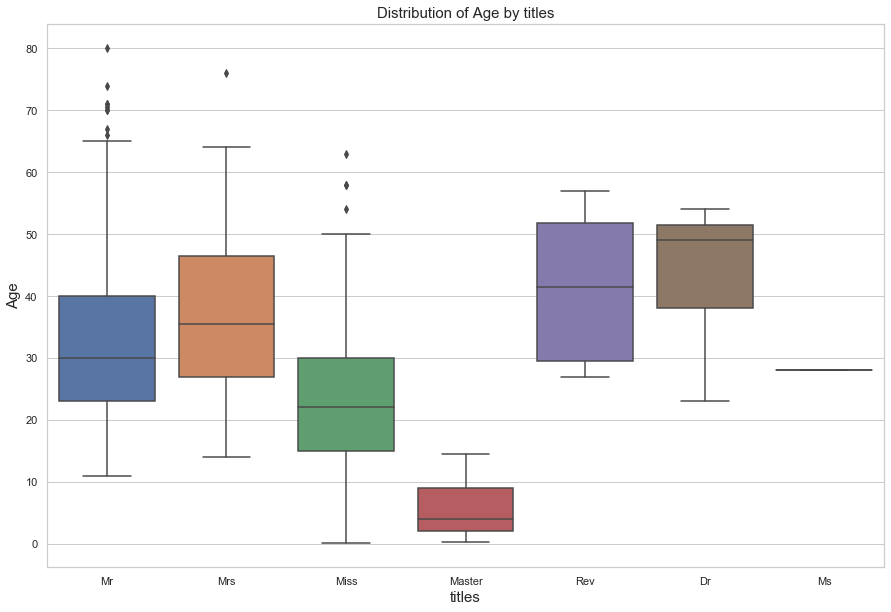

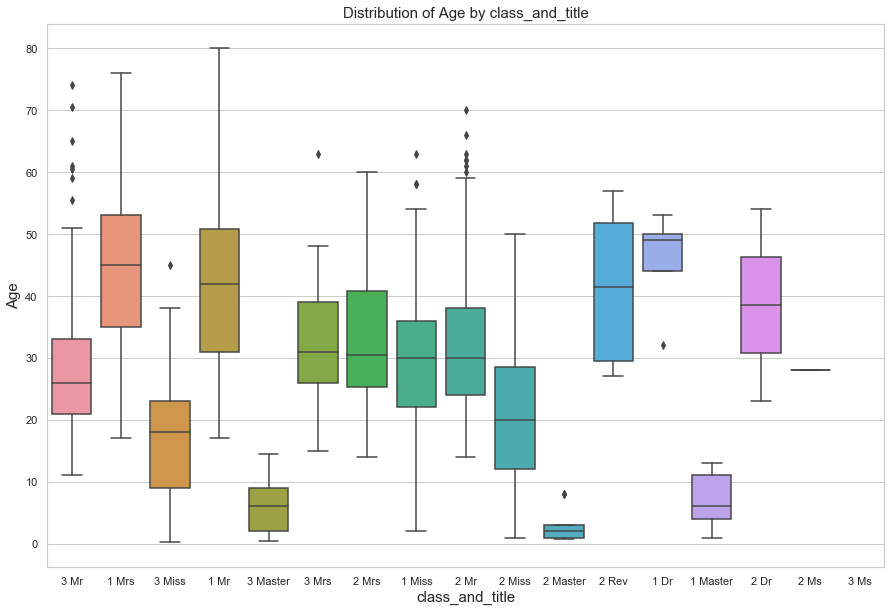

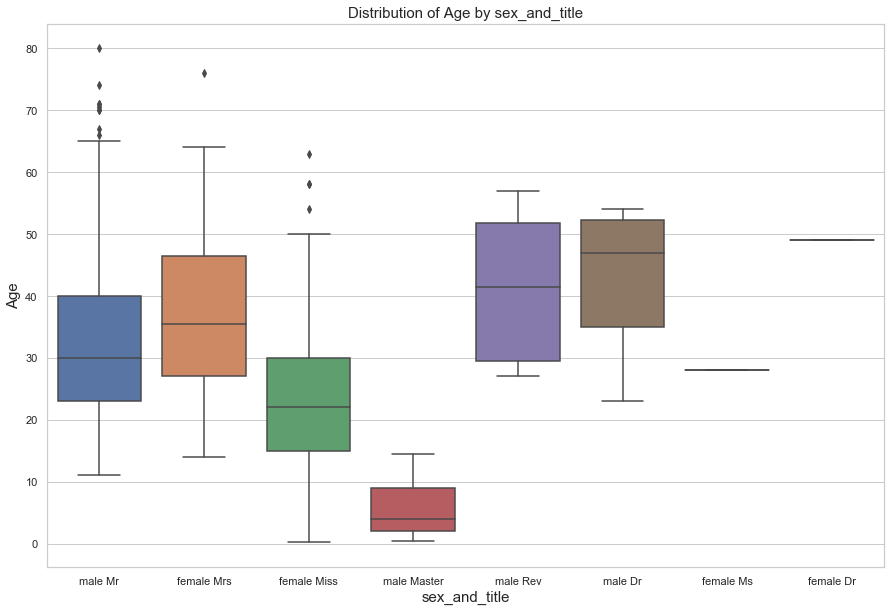

In [19]:
plot_box_plots(x_features = ['titles', 'class_and_title', 'sex_and_title'], y_feature = 'Age', df = testing_titles)

Based on the box plots shown above, grouping the data by passenger class and title introduces noise, which can be seen by the overlapping of the median values in the individual groups. This does not appear to be a useful feature for estimating the age. 

Grouping the age by sex and title does a better job of separating the data as the median age in each group is distinct, however upon further examination most of the titles are already gendered and it only adds further separation for some groups. This feature adds further separation for the group "female Dr", however as there are so few instances in this group, it may be more relevant to group all passengers with the title "Dr" together.  

Therefore, the title alone will be used impute the missing age values. Some of the groups ("Mr." and "Miss") have outliers, so the median rather than the mean will be used to impute the values. 

In [20]:
all_data_new = extract_titles(data_all,'titles')
all_data_new.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,titles
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [21]:
def impute_values(data, category, to_impute, method = 'median'): 
    '''
    data: the dataframe to transform 
    category: the category that will be used to impute missing values (column name as str)
    to_impute: the column containing values that need to be imputed (column name as str)
    method: the method to use to impute missing values: 'median', 'mean' or 'mode'
    '''
    
    if method == 'median': 
        data[to_impute] = data.groupby(category)[to_impute].transform(lambda x: x.fillna(x.median())) 
    elif method == 'mean': 
        data[to_impute] = data.groupby(category)[to_impute].transform(lambda x: x.fillna(x.mean()))
    elif method == 'mode': 
        data[to_impute] = data.groupby(category)[to_impute].transform(lambda x: x.fillna(x.mode()))
    else: 
        print("method should be 'median', 'mean', or 'mode'")
        return
    
    return data

In [22]:
impute_values(all_data_new, 'titles', 'Age')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,titles
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Mr
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,Mrs
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,Mr
416,30.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr


In [23]:
missing_vals_check = missing_values(all_data_new)
missing_vals_check

,feature,missing val count,missing val %
1,Cabin,1014,77.463713
10,Survived,418,31.932773
2,Embarked,2,0.152788
3,Fare,1,0.076394


As shown above, there are no longer any missing values in the 'Age' feature as they have been imputed using the median value from the passenger title.

#### Handling Missing Embarked Values

Next, the 2 missing values for the 'Embarked' feature will be handled. Because there are only 2 missing values which is less than 1%, the mode of the training data will be used to impute these missing values.

In [24]:
all_data_new['Embarked'] = all_data_new['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [25]:
all_data_new

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,titles
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Mr
414,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,Mrs
415,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,Mr
416,30.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr


In [26]:
missing_vals_check = missing_values(all_data_new)
missing_vals_check

,feature,missing val count,missing val %
1,Cabin,1014,77.463713
10,Survived,418,31.932773
3,Fare,1,0.076394


As shown above, the missing values for the 'Embarked' feature have been handled.

#### Handling Missing Fare Values

It seems logical that the fare values would be correlated with the passenger class, so I'm going to graph the median fare by passenger class to see if there is a relationship.

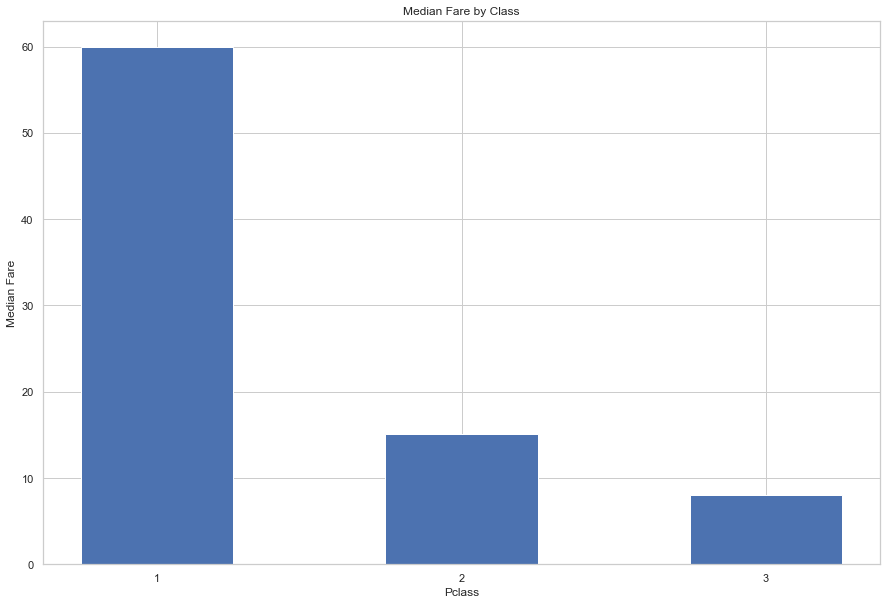

In [27]:
plt.bar([1,2,3], all_data_new.groupby('Pclass').median()['Fare'], width = 0.5)

plt.xlabel('Pclass') 
plt.ylabel('Median Fare') 
plt.title('Median Fare by Class') 
plt.xticks([1,2,3], (1, 2, 3))
plt.show()

As shown by the visualization above, the median fare decreases with class. Therefore, for the fare value I'm going to use the median fare value for the passenger's class to impute the missing values. 

In [28]:
all_data_new['Fare'] = data_all.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))

In [29]:
missing_vals_check = missing_values(all_data_new)
missing_vals_check

,feature,missing val count,missing val %
1,Cabin,1014,77.463713
10,Survived,418,31.932773


All the relevant missing values have now been handled, and we are left with missing values for "Survived", which is due to the testing data and "Cabin", which we are not using for prediction. 

### Feature Engineering

I'm going to create a new feature called 'family size' and explore if family size appears to be correlated with survival rate.

In [30]:
all_data_new['family_size'] = all_data_new['SibSp'] + all_data_new['Parch'] + 1

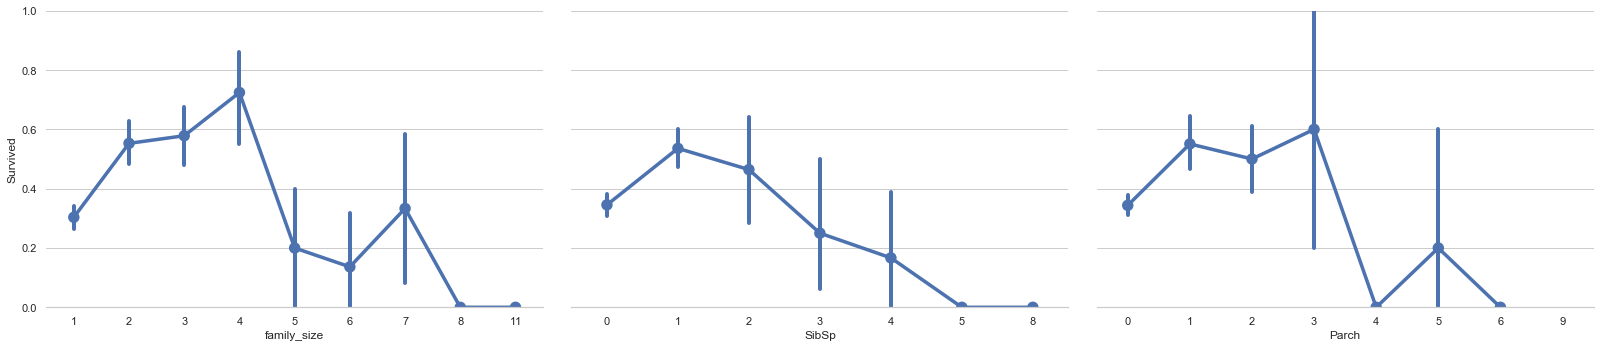

In [31]:
pairgrid(data=all_data_new, y='Survived', x=['family_size', 'SibSp', 'Parch'])

Based on the above, the features "family_size" and "SibSp" appear to be most correlated with survival rate. Within the family size feature I also notice several shifts in the survival rate as you increase in family size. I'm going to add another new feature to indicate the family size category.

In [32]:
all_data_new['family_category'] = ['small' if x >= 1 and x <=3 else 'medium' if x <=4 else 'medium-large' if x <=7 else 'very-large' for x in all_data_new['family_size']]

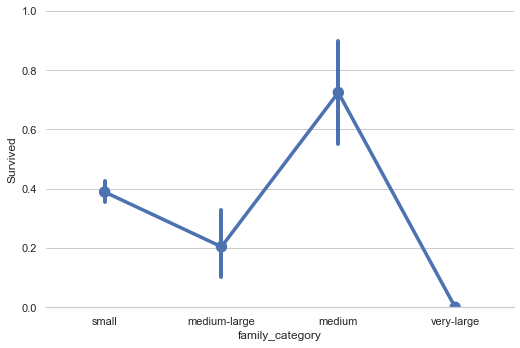

In [33]:
pairgrid(data=all_data_new, y='Survived', x='family_category')

The visualization above shows the changes in rate of survival as the family size category changes.

### Normalizing Numerical Columns

A logistic regression model requires that all numerical values are normalized prior to modelling, so I am going to normalize the data to a range between 0 and 1 using MinMaxScaler (Kelleher et al., 2015, p. 363). I selected this method as a method I use later to select features does not accept negative values.

In [34]:
num_cols = ['Age','Fare','Parch','SibSp','family_size']

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler = MinMaxScaler()
all_data_new[num_cols] = scaler.fit_transform(all_data_new[num_cols])

In [37]:
all_data_new.describe(include = 'all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,titles,family_size,family_category
count,1309.000000,295,1309,1309.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309,1309,1309.000000,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929,7,NaN,4
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343,Mr,NaN,small
freq,NaN,6,916,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11,767,NaN,1184
mean,0.368245,NaN,NaN,0.064951,NaN,0.042781,655.000000,2.294882,NaN,0.062357,0.383838,NaN,NaN,0.088388,NaN
std,0.164898,NaN,NaN,0.100997,NaN,0.096173,378.020061,0.837836,NaN,0.130207,0.486592,NaN,NaN,0.158364,NaN
min,0.000000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN
25%,0.273456,NaN,NaN,0.015412,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN
50%,0.373669,NaN,NaN,0.028213,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN
75%,0.442565,NaN,NaN,0.061045,NaN,0.000000,982.000000,3.000000,NaN,0.125000,1.000000,NaN,NaN,0.100000,NaN


The dataframe above shows the normalized data.

### Converting Categorical Features to Dummy Variables

To handle categorical features in the dataset, they are converted to dummy variables using one hot encoding. This adds a new binary feature for each level of the categorical variable. These features do not need to be normalized.

In [38]:
def create_dummy_cols(df, cols):

    data = [df]
      
    for i in cols: 
        dummies = pd.get_dummies(df[i],prefix=i)
        data.append(dummies)
    
    return pd.concat(data, axis = 1)

In [39]:
cat_cols = ['Embarked',  'Sex', 'Pclass', 'family_category']
all_data_new = create_dummy_cols(all_data_new, cat_cols)

In [40]:
all_data_new.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,family_category_medium,family_category_medium-large,family_category_small,family_category_very-large
0,0.273456,NaN,S,0.014151,"Braund, Mr. Owen Harris",0.0,1,3,male,0.125,...,1,0,1,0,0,1,0,0,1,0
1,0.473882,C85,C,0.139136,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,2,1,female,0.125,...,0,1,0,1,0,0,0,0,1,0
2,0.323563,NaN,S,0.015469,"Heikkinen, Miss. Laina",0.0,3,3,female,0.000,...,1,1,0,0,0,1,0,0,1,0
3,0.436302,C123,S,0.103644,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,4,1,female,0.125,...,1,1,0,1,0,0,0,0,1,0
4,0.436302,NaN,S,0.015713,"Allen, Mr. William Henry",0.0,5,3,male,0.000,...,1,0,1,0,0,1,0,0,1,0


### Correlation Matrix Heatmap

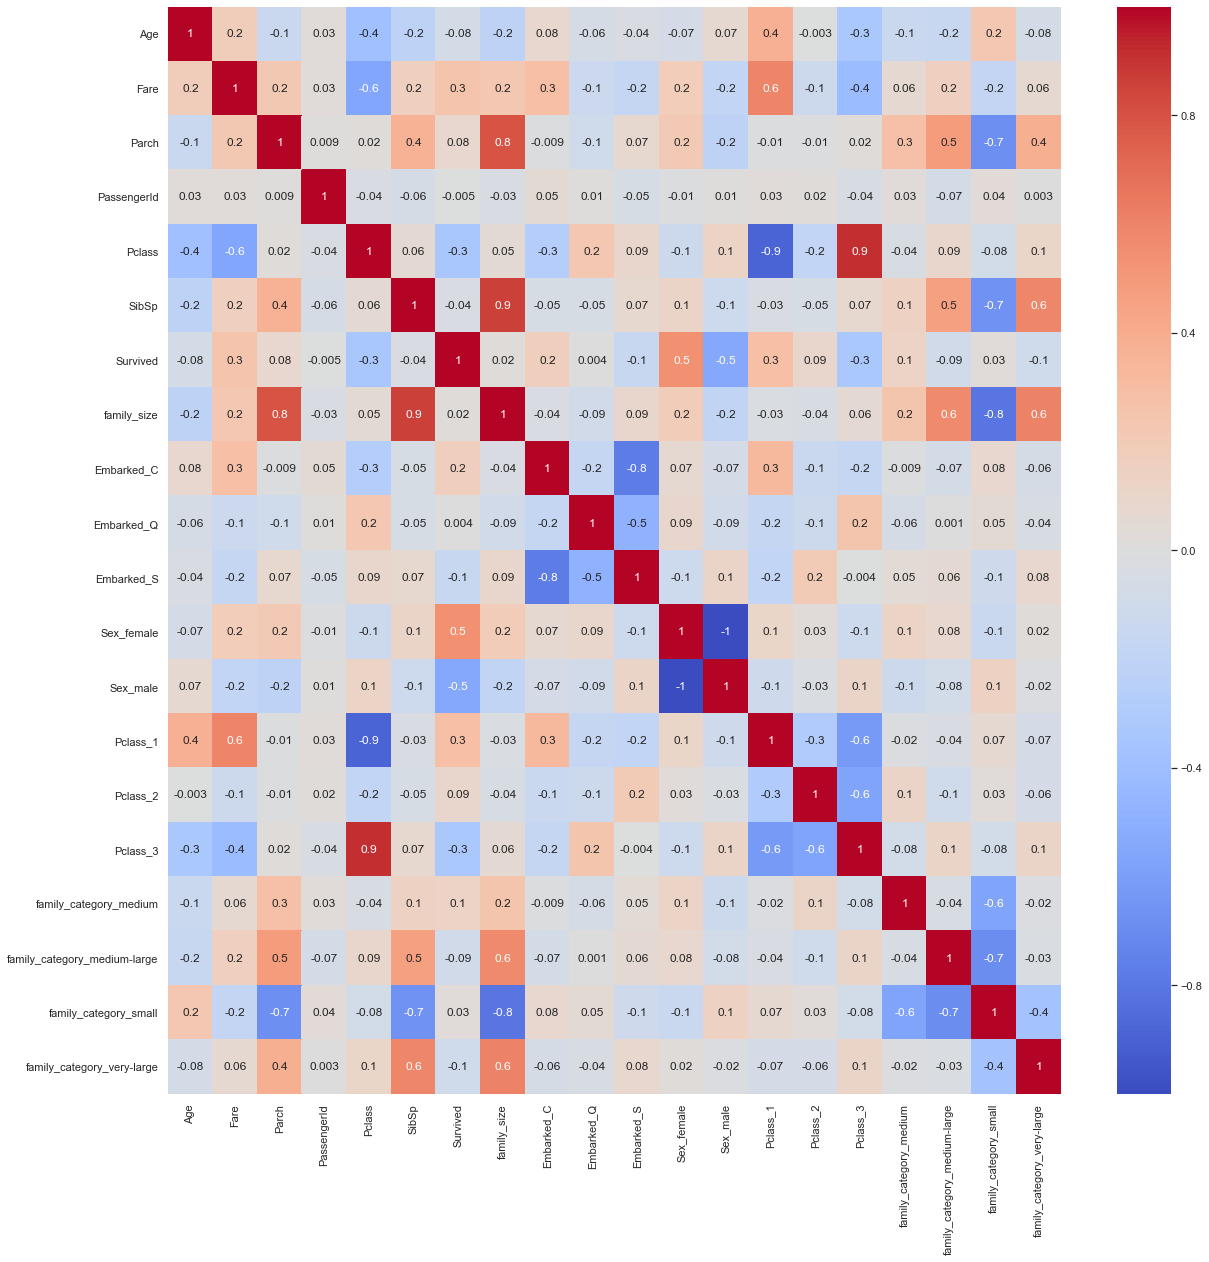

In [41]:
plt.figure(figsize=(20,20))
sns.heatmap(all_data_new.corr(), annot = True, fmt='.1g', cmap= 'coolwarm')

In [42]:
def get_top_abs_corr(df, target, no): 
    correlation = df.corr(method='pearson') #correlation coefficient
    correlation_all = abs(correlation[target])
    correlation_all_sorted = correlation_all.sort_values(ascending=False)
    correlation_all_sorted.drop(target,inplace=True)
    print(f'top {no} correlated variables by absolute value of the correlation coefficient')
    print(correlation_all_sorted.head(no))

In [43]:
get_top_abs_corr(all_data_new, 'Survived', 15)

top 15 correlated variables by absolute value of the correlation coefficient
Sex_male                        0.543351
Sex_female                      0.543351
Pclass                          0.338481
Pclass_3                        0.322308
Pclass_1                        0.285904
Fare                            0.257307
Embarked_C                      0.168240
Embarked_S                      0.149683
family_category_medium          0.128347
family_category_very-large      0.096040
Pclass_2                        0.093349
family_category_medium-large    0.089167
Parch                           0.081629
Age                             0.076986
SibSp                           0.035322
Name: Survived, dtype: float64


The top 15 most correlated variables with the target variable are shown above. This provides some idea of which features should be selected for modelling but I'm going to use a most robust feature selection method.

### Feature Selection

I'm going to separate the cleaned data back into testing and training data and use SelectKBest and manual feature selection to select the features for modelling. 

In [44]:
train_data_cleaned = all_data_new[all_data_new['Survived'].notnull()]
test_data_cleaned = all_data_new[all_data_new['Survived'].isnull()]

#### SelectKBest

In [45]:
from sklearn.feature_selection import SelectKBest, chi2

In [46]:
y = train_data_cleaned['Survived']
X = train_data_cleaned.drop(columns = ['Survived', 'Cabin', 'Embarked', 'Name', 'PassengerId', 'Pclass', 'Sex', 'Ticket', 'family_category', 'titles'])

In [47]:
selectk_classifier = SelectKBest(chi2, k=15)
selectk_classifier_fit_transform = selectk_classifier.fit_transform(X, y)

In [48]:
mask = selectk_classifier.get_support()
selected_features = X.columns[mask]

In [49]:
print('features selected using SelectKBest method:')
selected_features

features selected using SelectKBest method:


Index(['Age', 'Fare', 'Parch', 'SibSp', 'Embarked_C', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'family_category_medium', 'family_category_medium-large',
       'family_category_small', 'family_category_very-large'],
      dtype='object')

The features selected using the SelectKBest method are shown above. The number of features was tuned to select the number that produced the highest accuracy.

#### Manual Feature Selection Using Correlation Values

In [50]:
print(f'features selected manually using correlation value with target feature:')
features = ['Sex_female', 'Pclass_3', 'Pclass_1', 'Embarked_C', 'Fare', 'family_size']
features

features selected manually using correlation value with target feature:


['Sex_female', 'Pclass_3', 'Pclass_1', 'Embarked_C', 'Fare', 'family_size']

I compared the results of using the SelectKBest features, removing the co-correlated features from the features selected by SelectKBest and using the manually seleced features selected using the correlation values. I acheived the best results by using all the features selected by the SelectKBest model.

### Training and Testing Logistic Regression Model

#### Approach to Implementing Logistic Regression Model

Based on the information provided in the textbook "Fundamentals of Machine Learning for Predictive Data Analytics", I got an understanding of the concept of gradient descent as well as a high level algorithm for multivariable linear regression which can be adapted to logistic regression (Kelleher et al., 2015).

The sum of squared errors is used as the cost/loss function in linear regression, however this is not a good choice for logistic regression as it would result in a non-convex shaped error surface so a gradient descent algorithm may converge at a local minima if this function is used (Luo, 2019).

The cost function for logistic regression is (Pant, 2019):

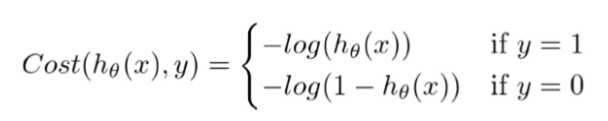

There are two conditions in this cost function, one for if y=1 and one for if y=0. These conditions can be combined to form a single cost function (Pant, 2019):

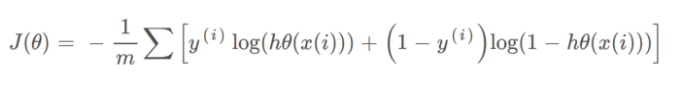

In this function, m is the number of training instances, y is the actual value and h_theta(x) is the predicted value.

To implement logistic regression, we also need the gradient of the cost function (the error delta term in the textbook) which is used to update the weight values on each iteration of the gradient descent function. The gradient of the cost function, or the derivative of the cost function with respect to each parameter of the weight vector is shown below (Pant, 2019):

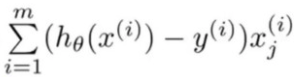

The high-level algorithm that was used to implement logistic regression is as follows:
1. Prepare the X and y data for modelling by converting both to matrices and adding a column of 1s to the X matrix so vector math can be applied using this variable. A vector of initial weights is also created with dimensions (number of features +1, 1).  
2. For each iteration of the gradient descent algorithm, a check is made to check that a global minimum has not yet been reach. This is done by comparing the cost value for the current iteration to a cost value of the previous iteration.
3. If the algorithm has not yet converged on a global minimum then the learning rate (alpha value) is set using a weight decay function (Kelleher et al., 2015, p. 349).
4. Next, the cost value and gradient is calculated for the current iteration. The current value of the cost function and the value for previous iteration are assigned.
5. The weight vector is updated by subtracting the learning rate multiplied by the gradient.
6. The algorithm repeats until the test that the algorithm has not yet converged fails and the converged weights are returned and the number of iterations required to reach the global minima is printed out. 
7. To make predictions using the learned weights, the sigmoid function is applied to the dot product of the X values and the learned weights

The functions that were created to implement logistic regression are shown below, these functions will be explained one by one.

#### Helper Functions for Logistic Regression

The "prepare_matrices" function converts the data from a dataframe format to a matrix format. To allow the descriptive feature data and the weights to be multiplied together, a column of 1s is added to the X matrix. Initial weights are created with the same number of rows as the number of features plus one and all the values are set to 1s.

In [51]:
def prepare_matrices(X, y): 
    '''
    convert data from dataframe format to matrix format required. 
    '''
    m = X.shape[0] # number of training instances
    n = X.shape[1] # number of features
    
    X = X.values
    
    # add a column with values of 1, so we can use the dot product
    X = np.append(np.ones((m,1)), X, axis = 1)
    
    initial_weights = np.zeros((n+1, 1))
    
    y = y.values
    
    return X, y, initial_weights

The "prepare_test" function is similar to the function above but it just converts the X testing data to the matrix format required, as no y data would be available and initial weights are not required for testing.

In [52]:
def prepare_test(X): 
    '''
    convert final testing data to format required.
    '''
    m = X.shape[0] # number of training instances
    n = X.shape[1] # number of features
    
    X = X.values
    
    # add a column with values of 1, so we can use the dot product
    X = np.append(np.ones((m,1)), X, axis = 1)
    
    return X

The "sigmoid" function taks an input and applies the sigmoid function which returns values between 0 and 1. 

In [53]:
def sigmoid(x): 
    return np.divide(1 , (1 + np.exp(-x)))

The "calc_cost" function takes as an input the current weight values as a vector, the matrix of X values and a vector of y values and computs the cost and the gradient of the cost function. The gradient is the derivative of the cost function with respect to each parameter in the weight vector and indicates the direction that the weights should be adjusted. 

In [54]:
def calc_cost(w, X, y):
    '''
    w: the vector containing the current weight values 
    X: x values 
    y: y values 
    '''
    
    m = len(y)

    model_value = sigmoid(X@w)
    y_1 = -y.T@np.log(model_value) # if y=1
    y_0 = -(1-y).T@np.log(1-model_value) # if y=0
    
    cost = (1/m) * (y_1 + y_0)
    
    gradient = (1/m) * X.T@np.subtract(model_value,y)
                            
    return cost, gradient

The "set_alpha" function adjusts the learning rate with each iteration, so that smaller and smaller steps are taken as the number of iterations increases (Kelleher et al., 2015, p. 349).

In [55]:
def set_alpha(t, c=100, a0=0.2): 
    '''
    a0: initial alpha value 
    c: constant that controls how quickly the learning rate decays. 
    t: the current iteration 
    '''
    
    alpha = a0 * (c/(c + t))
    
    return alpha 

The "is_converged" function checks if the gradient descent algorithm has reached the global minimum based on the difference between the current cost value and the value from the previous iteration. A threshold is set to define the difference that is small enough to stop the gradient descent.

In [56]:
def is_converged(c0, c1, diff):
    '''
    c0: last itr cost value
    c1: current itr cost value
    diff: smallest difference between current and previous cost value to stop iterating
    '''
    
    if abs(c1 - c0) < diff: 
        return True 
    else: 
        return False     

The "grad_descent" function first checks that the weights have not yet converged. If they have not then the learning rate (alpha) is set using the weight decay function (set_alpha) and the cost and gradient are calculated. The current cost value and the value from the previous iteration are updated. The weight values are updated using the learning rate and the gradient value. Once converged, the converged weights are returned by the function.

In [57]:
def grad_descent(initial_weights, diff_threshold, X, y): 
    
    '''
    the output from this function should be the weights that are learned through gradient descence 
    '''
    
    itr = 0
    
    c0 = 0 
    c1 = 0

    
    while is_converged(c0, c1, diff=diff_threshold) == False or itr==0:
        alpha = set_alpha(t=itr)
        cost, grad = calc_cost(w=initial_weights, X=X, y=y) 
        c0 = c1
        c1 = cost
        initial_weights = np.subtract(initial_weights, np.dot(alpha, grad))
        
        itr +=1
            
    converged_weights = initial_weights
    print(f'converged on iteration: {itr}')
    
    return converged_weights

In [58]:
def save_submission(df, filename='my_submission.csv'): 
    df.to_csv(filename, index=False)

#### Functions to Train the Model, Made Predictions and Show Accuracy

The "train_model" trains the logistic regression by applying gradient descent to learn the weights for the parameters.

In [59]:
def train_model(X_train, y_train):
    '''
    X_train: a dataframe containing the x training data 
    y_train: a dataframe containing the y training data 
    
    '''
    
    X, y, initial_training_weights = prepare_matrices(X=X_train, y=y_train)
    
    converged_weights_training = grad_descent(initial_weights=initial_training_weights, diff_threshold=0.000001, X=X, y=y)
    
    return converged_weights_training

The "predict" function applies the learned weights to the data values and passes them to the sigmoid function to get the predicted values. Because the sigmoid function returns values between 0 and 1, values that are equal to or greater than 0.5 are mapped to a 1 (survived) and values that are less than 0.5 are mapped to a 0 (did not survive). The predicted values are saved to a dataframe and the function returns the dataframe and the predictions.

In [60]:
def predict(X_test, converged_weights_training, id_labels): 
    '''
    X_test: a dataframe containing the x test data 
    converged_weights_training: a vector containing the weights that were converged upon using the train model function 
    the output of this function is a dataframe containing the predicted values for survival
    '''
    
    X = X_test
    X = prepare_test(X)
    
    prediction = sigmoid(X@converged_weights_training)
    
    # convert the predict values to 0s and 1s based on the output of the sigmoid function 
    
    for value in prediction:
        if value[0] >= 0.5:
            value[0] = 1
        else: 
            value[0] = 0
        
    predictions_to_list = list(map(lambda x: int(x[0]), prediction))
    predictions = pd.Series(predictions_to_list)
    
    id_labels.reset_index(drop=True, inplace=True)
    
    output = pd.DataFrame({'PassengerId': id_labels, 'Survived': predictions})
    
    return output, prediction

The accuracy is calculated using the "accuracy_score" function which compares the predicted to the actual values. The percentage of correct values is returned.

In [61]:
def accuracy_score(predictions, y):
    '''
    predictions: the predicted values, as a numpy array 
    y: the y-value labels, as a numpy array
    '''
    
    correct = 0
    
    for i in range(0, len(predictions)): 
        predicted = int(predictions[i][0])
        actual = int(y[i][0])
        if predicted == actual: 
            correct += 1

    perc_correct = correct / len(y)*100
    
    print(f'the accuracy of the model is: {perc_correct:.3f}')
    return perc_correct 

#### Training and Testing the Implemented Logistic Regression Model on a 30% Split of the Labelled Data

I'm going to test my model on a section of the labelled training data provided so I can get an idea of how it is performing before I submit the predictions to Kaggle. Based on a 30% split of the labelled data, the accuracy of the model is 81.716%. This accuracy was calculated after testing different combinations of testing features. The parameters of the logistic regression model (initial alpha value and threshold value for convergence) we also tuned to select the values that produced the highest accuracy.

In [62]:
from sklearn.model_selection import train_test_split

all_X = train_data_cleaned
all_y = train_data_cleaned[['Survived']]

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.3,random_state=0)

In [63]:
selected_features = ['Age', 'Fare', 'Parch', 'SibSp', 'Embarked_C', 'Embarked_S',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'family_category_medium', 'family_category_medium-large',
       'family_category_small', 'family_category_very-large']

In [64]:
X_train=train_X[selected_features]
y_train=train_y
id_labels = test_X['PassengerId']
X_test = test_X[selected_features]
y_test = test_y[['Survived']].to_numpy()

In [65]:
weights = train_model(X_train, y_train)

converged on iteration: 2754


In [66]:
output, prediction = predict(X_test=X_test, converged_weights_training=weights, id_labels=id_labels)

In [67]:
output

,PassengerId,Survived
0,496,0
1,649,0
2,279,0
3,32,1
4,256,1
...,...,...
263,264,0
264,719,0
265,621,0
266,787,1


In [68]:
acc = accuracy_score(prediction, y=y_test)

the accuracy of the model is: 81.716


#### K-fold Cross Validation

I'm also going to test my model on different splits of the data using K-fold Cross Validation. As shown below, the average accuracy of the splits is 80.58%.

In [69]:
from sklearn.model_selection import KFold

In [70]:
def kFoldCrossVal(n, selected_features):  
    
    '''
    n : number of splits 
    model : the classifier to validate

    I wrote a similar version of this function for my group's project
    
    '''
    
    kf = KFold(n_splits=n, shuffle=True, random_state=0)

    X = train_data_cleaned
    y = train_data_cleaned[['Survived']]

    split = 0
    scores = 0
    
    for train_index, test_index in kf.split(X):
        x_train, x_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        
        X_train=x_train[selected_features]
        id_labels = x_test['PassengerId']
        X_test = x_test[selected_features]
        y_test = y_test[['Survived']].to_numpy()
        
        weights = train_model(X_train, y_train)
        
        _, prediction = predict(X_test=X_test, converged_weights_training=weights, id_labels=id_labels)
        
        score = accuracy_score(prediction, y=y_test)
        score /= 100 #converting to decimal value
 
        scores += score
        split += 1 
        print(f'split number {split}')
        print('\n')

    avg_score = scores / n
    print(f'average accuracy score: {avg_score:.2%}')

In [71]:
kFoldCrossVal(5, selected_features)

converged on iteration: 2805
the accuracy of the model is: 81.564
split number 1


converged on iteration: 2469
the accuracy of the model is: 78.652
split number 2


converged on iteration: 3113
the accuracy of the model is: 80.337
split number 3


converged on iteration: 3193
the accuracy of the model is: 81.461
split number 4


converged on iteration: 2247
the accuracy of the model is: 80.899
split number 5


average accuracy score: 80.58%


The range of accuracy values and average accuracy score for the function is shown above.

### Generating Kaggle Predictions

Next, I'm going to train my model on the entire training dataset to learn the parameter weights and generate predictions using the testing dataset.

#### Training the model on the full training dataset

In [72]:
X_train=train_data_cleaned[selected_features]
y_train=train_data_cleaned[['Survived']]
id_labels = test_data_cleaned['PassengerId']
X_test = test_data_cleaned[selected_features]

In [73]:
weights = train_model(X_train, y_train)

converged on iteration: 2692


In [74]:
output, prediction = predict(X_test=X_test, converged_weights_training=weights, id_labels=id_labels)

In [75]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [76]:
save_submission(output, filename='submission.csv')

### Kaggle Accuracy and Leaderboard Position

My score of 77.99% and my position on the leaderboard (4784/18322, top 27%) is shown below. My actual score is lower than the score I calculated by testing the model on sections of the training data which suggests that my model is overfitting. After some reading online, I think I could improve my model by adding a regularization term to the gradient descent function to penalize some of the coefficients to prevent overfitting. 

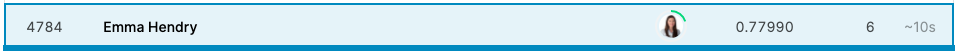

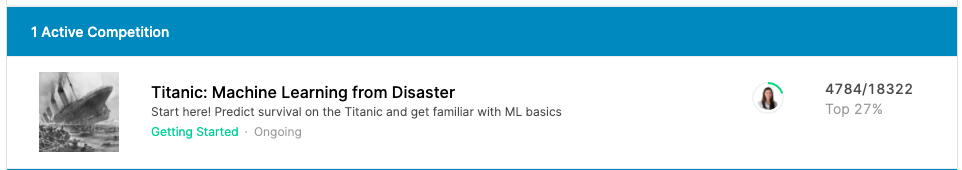

### References

Kelleher, J. D., Namee, B. M., & D'Arcy, A. (2015). Fundamentals of machine learning for predictive data analytics: Algorithms, worked examples, and case studies. Cambridge, Massachusetts: MIT Press.

Leslie, J. (2018, November 21). Titanic: EDA, wrangling &amp; imputation. Retrieved November 27, 2020, from https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation

Luo, S. (2019, June 07). Optimization: Loss Function Under the Hood (Part II). Retrieved November 27, 2020, from https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

Pant, A. (2019, January 22). Introduction to Logistic Regression. Retrieved November 27, 2020, from https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148